<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/Weighting/pneumonia_playaround_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [ ]:
! pip install -q kaggle
from google.colab import files

In [ ]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumachii","key":"f8cd305bf4afae205ea340858ca16b92"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:42<00:00, 53.8MB/s]
100% 2.29G/2.29G [00:42<00:00, 58.3MB/s]


In [ ]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [ ]:
!ls

chest-xray-pneumonia.zip  files  kaggle.json  sample_data


# X-ray Image Classification 

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using Convolutional Neural Networks. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle.


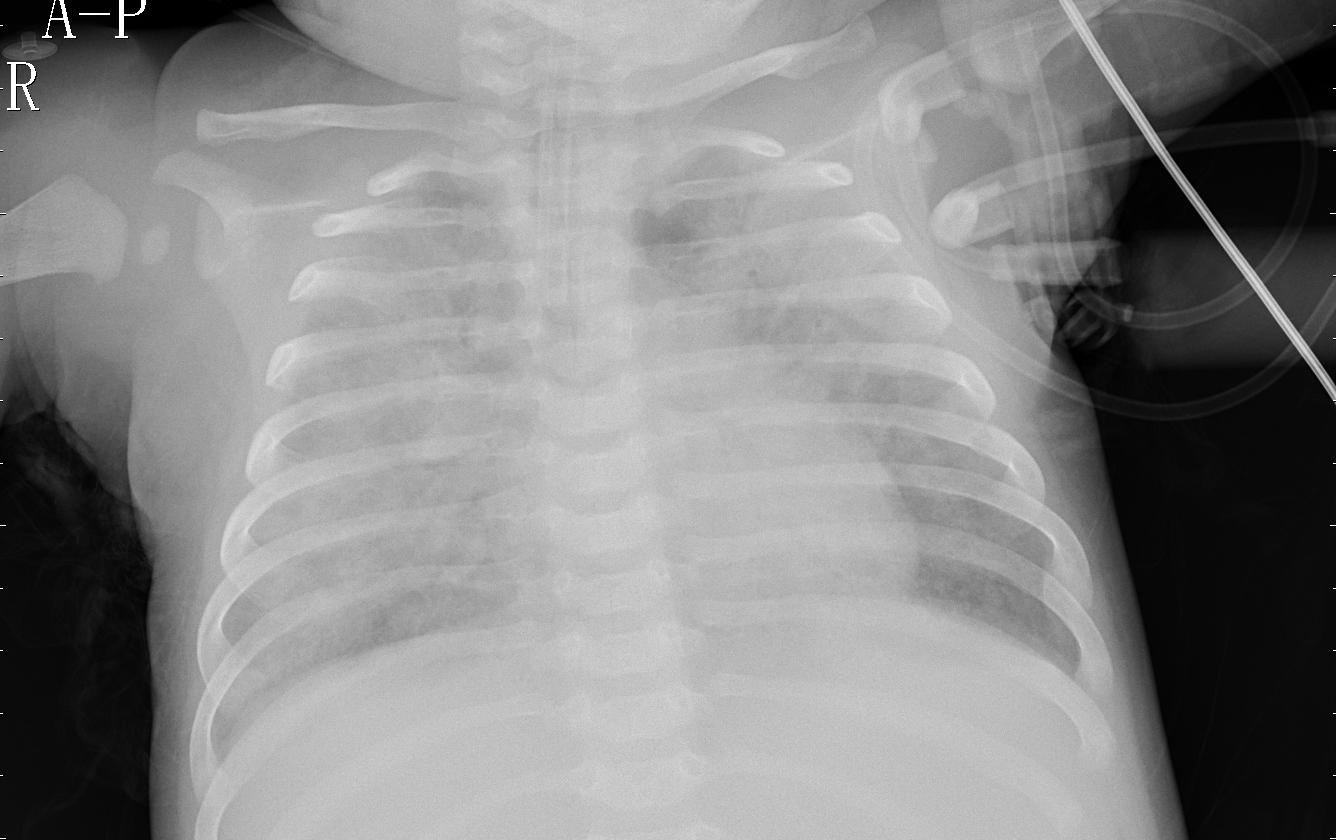

In [ ]:
# The local path to the target image
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

Stuff about preprocessing

# Binary Classification

For our first model, we will first take the images from our drive, and preprocess them into data that can be fed into a CNN.

For this section, we will focus on predicting whether a patient has pneumonia or not.

In [ ]:
def load_data(path):

  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      # img = preprocess_input(x)
      # imgs.append(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels


In [ ]:
# validation data was used as training data to debug things
X_train, y_train = load_data("/content/files/chest_xray/train")
X_test, y_test = load_data("/content/files/chest_xray/test")
# X_val, y_val = load_data("/content/files/chest_xray/val")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## CNN

We will be testing our data on a simple CNN, with a dropout rate of 0.5.

In [ ]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [ ]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size,class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 24s 149ms/step - loss: 0.5900 - accuracy: 0.7418 - f1_m: 0.8476 - precision_m: 0.7470 - recall_m: 0.9891 - val_loss: 0.5593 - val_accuracy: 0.7089 - val_f1_m: 0.8054 - val_precision_m: 0.6893 - val_recall_m: 0.9772
Epoch 2/20
163/163 [==============================] - 24s 149ms/step - loss: 0.4561 - accuracy: 0.7864 - f1_m: 0.8590 - precision_m: 0.8257 - recall_m: 0.9150 - val_loss: 0.4573 - val_accuracy: 0.8125 - val_f1_m: 0.8550 - val_precision_m: 0.8124 - val_recall_m: 0.9076
Epoch 3/20
163/163 [==============================] - 24s 148ms/step - loss: 0.3963 - accuracy: 0.8309 - f1_m: 0.8869 - precision_m: 0.8661 - recall_m: 0.9184 - val_loss: 0.4199 - val_accuracy: 0.8306 - val_f1_m: 0.8703 - val_precision_m: 0.8292 - val_recall_m: 0.9210
Epoch 4/20
163/163 [==============================] - 24s 148ms/step - loss: 0.3580 - accuracy: 0.8508 - f1_m: 0.8999 - precision_m: 0.8848 - recall_m: 0.9238 - val_loss: 0.3292 - val_accuracy:

In [ ]:
model.evaluate_generator(gen_test, 50, workers=1)

[0.3136981725692749,
 0.8766025900840759,
 0.9064379930496216,
 0.8439423441886902,
 0.9856219291687012]

In [ ]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Chance of Pneumonia:", (preds))

Chance of Pneumonia: [[0.49924982]]
Chance of Pneumonia: [[0.08622199]]
Chance of Pneumonia: [[0.34004495]]
Chance of Pneumonia: [[0.9030905]]
Chance of Pneumonia: [[0.5159008]]
Chance of Pneumonia: [[0.8829603]]
Chance of Pneumonia: [[0.52448803]]
Chance of Pneumonia: [[0.06770035]]
Chance of Pneumonia: [[0.11854523]]
Chance of Pneumonia: [[0.97827464]]
Chance of Pneumonia: [[0.03267264]]
Chance of Pneumonia: [[0.13491686]]
Chance of Pneumonia: [[0.01802282]]
Chance of Pneumonia: [[0.2730748]]
Chance of Pneumonia: [[0.525064]]
Chance of Pneumonia: [[0.72124517]]
Chance of Pneumonia: [[0.75907296]]
Chance of Pneumonia: [[0.02721829]]
Chance of Pneumonia: [[0.03737004]]
Chance of Pneumonia: [[0.979106]]
Chance of Pneumonia: [[0.27083135]]
Chance of Pneumonia: [[0.88072354]]
Chance of Pneumonia: [[0.80965954]]
Chance of Pneumonia: [[0.53337]]
Chance of Pneumonia: [[0.01668025]]
Chance of Pneumonia: [[0.08265115]]
Chance of Pneumonia: [[0.03277837]]
Chance of Pneumonia: [[0.2614594]]
Chan

In [ ]:
# our code has a 91% validation accuracy on test data

In [ ]:
img_path = "/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg"

# preds = model.predict(np.expand_dims(X_test[340], axis=0))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x
# print(img)

preds = model.predict(img)


print("Predicted:", (preds))

Predicted: [[0.9992223]]


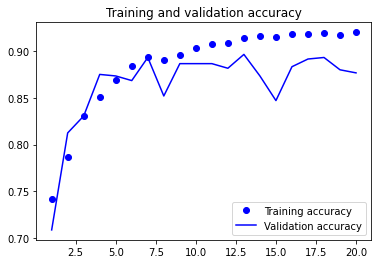

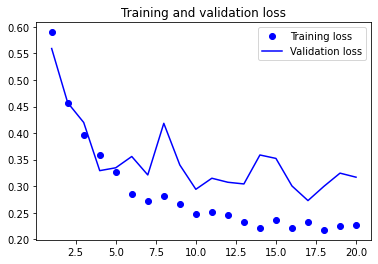

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

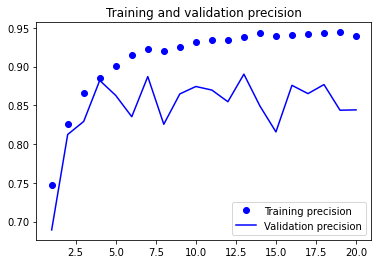

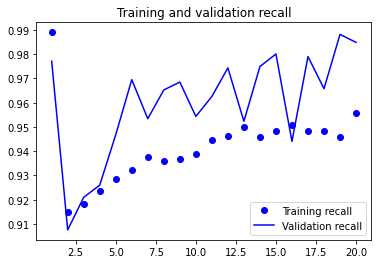

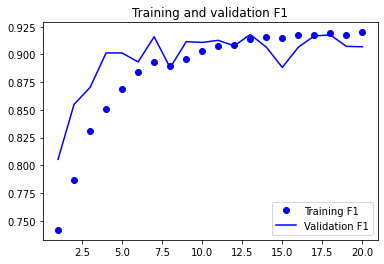

In [ ]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

In [ ]:
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# model.fit(X_val, y_val, epochs=15, batch_size=32) #this line is for debug purposes

# things to consider
# cost function for false negatives and false positives
# slightly unbalanced data set -- oversample? undersample? both?
# three-way classification section

We graph our stuff here

##Imbalanced Data

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

In [ ]:
!pip install imblearn 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

#X_train_S, y_train_S = smote.fit_sample(X_train,y_train)


print(X_train[1])

In [ ]:
from collections import Counter
print(Counter(y_train_S))

# HEAT MAPS!

In [ ]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposition(img_path, heatmap):
  # We load the original image
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "elephant_cam.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

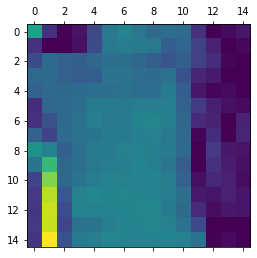

In [ ]:
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

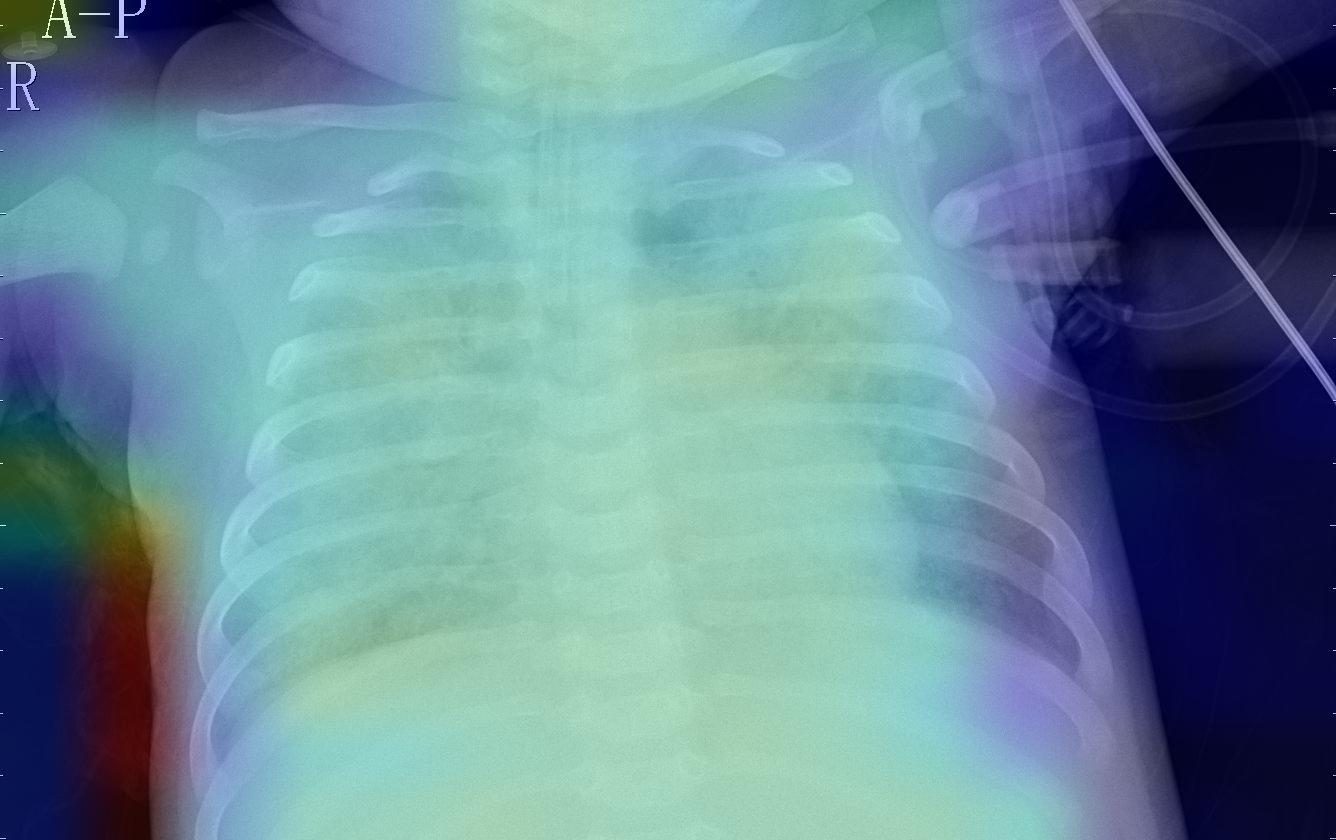

In [ ]:
superimposition("/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg", heatmap)

# Three-Way Classification

We will now be processing our data such that we will also be taking into consideration, the type of pneumonia one can be diagnosed with -- bacterial and viral.

In [ ]:
def load_data_2(path):
  imgs = []
  labels = []

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)

      # one-hot encoded labels
      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])


      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

      

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels

In [ ]:
X_train, y_train = load_data_2("/content/files/chest_xray/train")
X_test, y_test = load_data_2("/content/files/chest_xray/test")
print(y_test)

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


We will now prepare our dataset for easy pphoto access

In [ ]:
# prepare three-way categorical data directories for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data directories for testing
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..

/content/files/chest_xray/train
/content/files/chest_xray/train/PNEUMONIA
/content/files/chest_xray/train
BACTERIA  NORMAL  VIRUS
/content/files/chest_xray/test
/content/files/chest_xray/test/PNEUMONIA
/content/files/chest_xray/test
/content


In [ ]:
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
'''

'\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img\n\nbatch_size = 128\n\ntraingen = ImageDataGenerator(\n    rescale= 1./255,\n    rotation_range =45,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip = True\n\n)\n\ntestgen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = traingen.flow_from_directory(\n        "/content/files/chest_xray/train",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\nvalidation_generator = testgen.flow_from_directory(\n        "/content/files/chest_xray/test",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\n'

In [ ]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [ ]:
# history = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)

In [ ]:
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1], 2:class_weight[2]}
print(class_weights)

batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size,class_weight=class_weights)

Epoch 1/30
163/163 [==============================] - 24s 145ms/step - loss: 1.0407 - accuracy: 0.4998 - f1_m: 0.2341 - precision_m: 0.4172 - recall_m: 0.1802 - val_loss: 1.0643 - val_accuracy: 0.4194 - val_f1_m: 0.4071 - val_precision_m: 0.4946 - val_recall_m: 0.3470
Epoch 2/30
163/163 [==============================] - 24s 144ms/step - loss: 0.9170 - accuracy: 0.5761 - f1_m: 0.4996 - precision_m: 0.6622 - recall_m: 0.4135 - val_loss: 0.8660 - val_accuracy: 0.6694 - val_f1_m: 0.5216 - val_precision_m: 0.8758 - val_recall_m: 0.3766
Epoch 3/30
163/163 [==============================] - 23s 143ms/step - loss: 0.8398 - accuracy: 0.6296 - f1_m: 0.5768 - precision_m: 0.7006 - recall_m: 0.4954 - val_loss: 0.7388 - val_accuracy: 0.6645 - val_f1_m: 0.6436 - val_precision_m: 0.8110 - val_recall_m: 0.5362
Epoch 4/30
163/163 [==============================] - 23s 143ms/step - loss: 0.8107 - accuracy: 0.6375 - f1_m: 0.5989 - precision_m: 0.6968 - recall_m: 0.5299 - val_loss: 0.7448 - val_accuracy:

In [ ]:
model.evaluate_generator(gen_test, 50, workers=1)

[0.651969850063324,
 0.8012820482254028,
 0.7808741331100464,
 0.8463922739028931,
 0.729687511920929]

In [ ]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Predicted:", (preds))

Predicted: [[0.52488244 0.2502827  0.22483489]]
Predicted: [[0.5815823  0.31964803 0.09876971]]
Predicted: [[0.1883508  0.38424137 0.4274078 ]]
Predicted: [[0.88972366 0.05201329 0.0582631 ]]
Predicted: [[0.48171332 0.2064727  0.311814  ]]
Predicted: [[0.13286862 0.3957932  0.47133812]]
Predicted: [[0.26224783 0.43425465 0.30349755]]
Predicted: [[0.6094482  0.15034859 0.24020319]]
Predicted: [[0.7902528  0.13793588 0.0718113 ]]
Predicted: [[0.04555706 0.50233316 0.45210975]]
Predicted: [[0.8417133  0.05840382 0.09988291]]
Predicted: [[0.56576127 0.2577387  0.17650002]]
Predicted: [[0.8389796  0.05503048 0.10598995]]
Predicted: [[0.24135064 0.32355082 0.43509856]]
Predicted: [[0.35655874 0.4070532  0.23638807]]
Predicted: [[0.37936905 0.3419813  0.27864963]]
Predicted: [[0.50236475 0.16607592 0.3315593 ]]
Predicted: [[0.75084436 0.10759092 0.1415647 ]]
Predicted: [[0.8165716  0.0957829  0.08764548]]
Predicted: [[0.01216986 0.45348066 0.53434944]]
Predicted: [[0.5725933  0.16162671 0.265

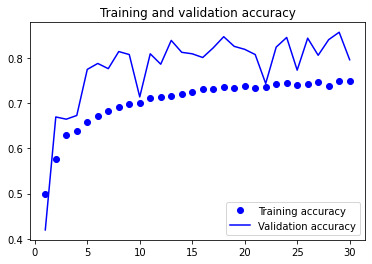

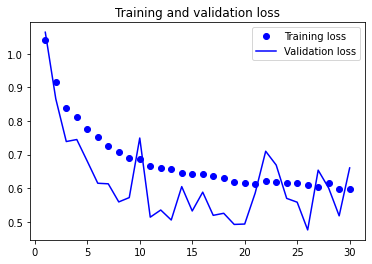

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

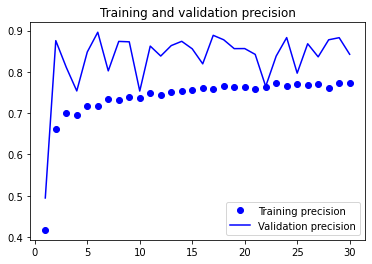

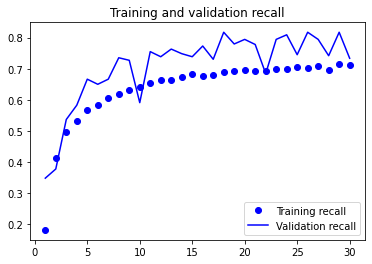

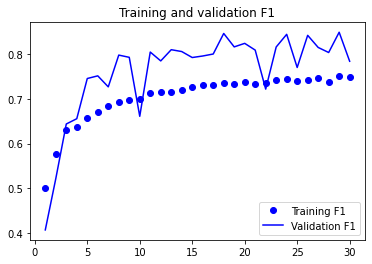

In [ ]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

In [ ]:
img_path = "/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg"

# preds = model.predict(np.expand_dims(X_test[340], axis=0))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x
# print(img)

preds = model.predict(img)

# todo: get those labels up
# order: normal, bacterial, viral
print("Predicted:", (preds))

Predicted: [[0.0006245  0.5807905  0.41858497]]


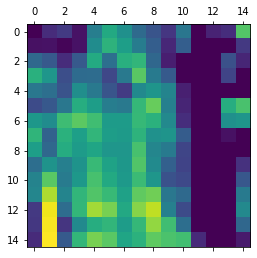

In [ ]:
img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

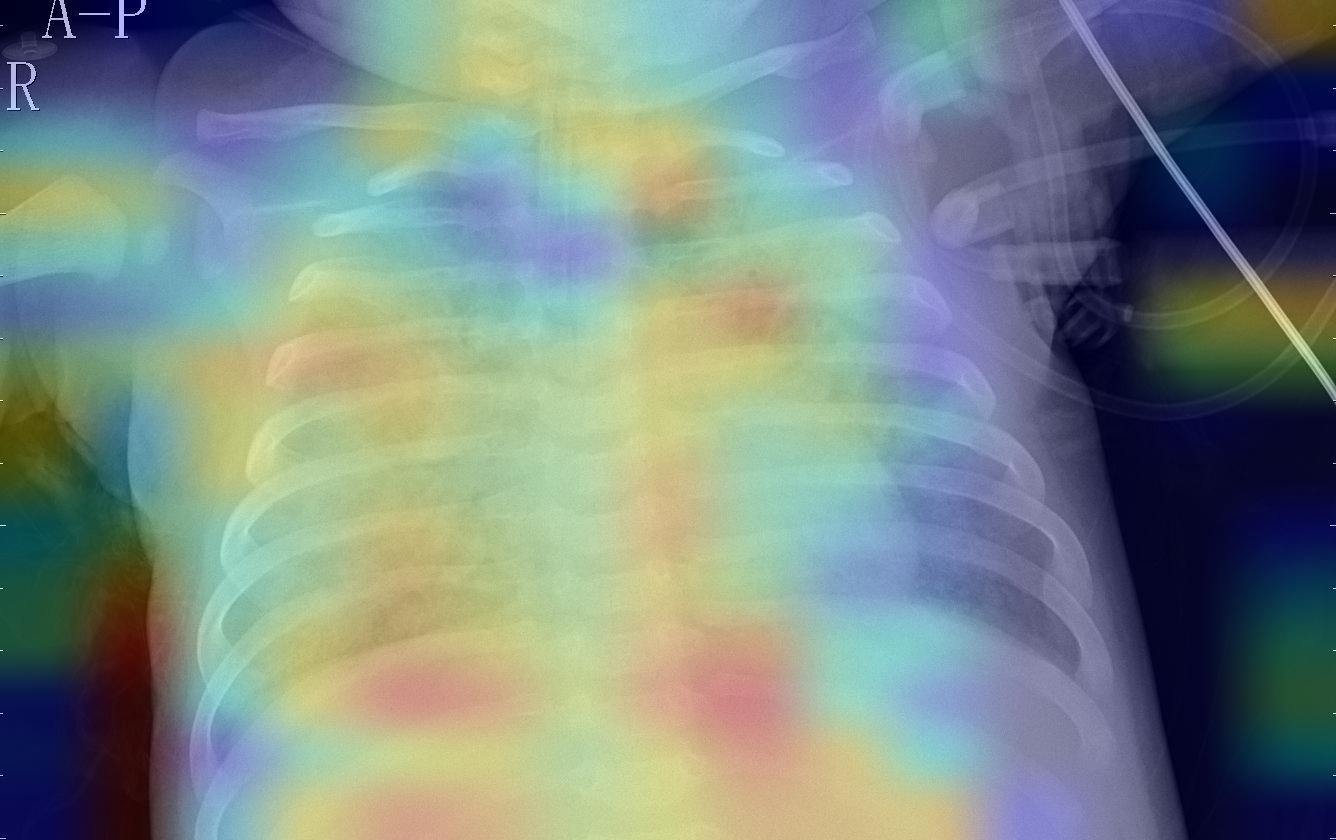

In [ ]:
superimposition("/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg", heatmap)

# MORE HEAT MAPS

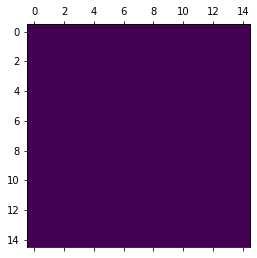

In [ ]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
#SALIENCY

# sampling if needed

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

Since there is a significant imbalance of bacterial data compared to normal and viral data, we will be oversampling the normal and viral data accordingly.

In [ ]:
# prepare the oversampling data

X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

In [ ]:
# in order for the data to be more or less equal, random sampling is used.
# viral and bacterial data will be oversampled to a size of 2500 in order to
# maintain an even ratio 

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

In [ ]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train = np.concatenate((X_train, X_train_concatenate_normal), axis=0)
X_train = np.concatenate((X_train, X_train_concatenate_viral))


# new Y_train
y_train = np.concatenate((y_train, y_train_concatenate_normal))
y_train = np.concatenate((y_train, y_train_concatenate_viral))

print(X_train.shape)

The proportions of the data have now been rebalanced to a relatively equal distribution.

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

In [ ]:
# rudimentary CNN for the three-way classification
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# todo: heatmaps! heatmaps! heatmaps! might turn the heatmaps into a whole function unto itself.

classifier_layer_names = [
    "dense_1"
]
img_array = preprocess_input(get_img_array(img_path, size = (299, 299)))

last_conv_layer = model.get_layer("block14_sepconv2_act")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
# for layer_name in classifier_layer_names:
#     x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    # print(preds[:, top_pred_index])
    top_class_channel = preds[:]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

print(pooled_grads.shape)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)